In [23]:
from pathlib import Path
import os, sys
import pandas as pd
import re
import matplotlib.pyplot as plt

# move working dir from notebooks/ -> repo root and expose it to Python
repo_root = Path.cwd().parent
os.chdir(repo_root)
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from common.config_manager import ConfigManager
from common.utils.io import read_csv

In [9]:

# Import ConfigManager, that handles all configurations and file paths
config_manager = ConfigManager(Path.cwd())

# Project config
project_config = config_manager.project()
curated_dir = Path(project_config["paths"]["extraction_curated"])

# Path to each CSV - saved on .yamls in configs/
processed_dir = Path(project_config["paths"]["core_processed"])
core_processed_path = processed_dir / "dataset_full.csv"

dataset_full = read_csv(core_processed_path)

len(dataset_full)


159512

---


# Profiling - Quick overview

We start by getting a feel for the dataset: shape, columns, and a `describe().T` so we see ranges, uniques, and common values.

In [10]:
dataset_full.head(3)

,scrobble_number,username,track_name,track_mbid,date,artist_name,artist_mbid,album_name,album_mbid,artist_listeners,...,album_playcount,spotify_track_id,spotify_album,spotify_release_date,spotify_duration_ms,spotify_popularity,spotify_genres,week_saturday_utc,added_at_utc,is_week_favorite
0,1,Tyains,Blue World,4cc09066-a971-46aa-bf25-aeb98169cd5f,2020-03-31 23:50:00,Mac Miller,a0e8a1b1-5f8f-475a-a253-17415c17d0ff,Circles (Deluxe),NaN,2592573,...,9640567.0,2hwOoMtWPtTSSn6WHV7Vp5,Circles,2020-01-17,209440.0,72.0,NaN,2020-03-28 00:00:00,NaN,0
1,2,Tyains,Complicated,3f60054f-b183-4f66-8133-23905a37c847,2020-03-31 23:46:00,Mac Miller,a0e8a1b1-5f8f-475a-a253-17415c17d0ff,Circles (Deluxe),NaN,2592573,...,9640567.0,3WfSNAoj2D8C9noPSGZZFM,Circles,2020-01-17,232211.0,62.0,NaN,2020-03-28 00:00:00,NaN,0
2,3,Tyains,Circles,54fda115-7237-49af-8559-fcf45713b69c,2020-03-31 23:43:00,Mac Miller,a0e8a1b1-5f8f-475a-a253-17415c17d0ff,Circles (Deluxe),NaN,2592573,...,9640567.0,4jXl6VtkFFKIt3ycUQc5LT,Circles,2020-01-17,170360.0,66.0,NaN,2020-03-28 00:00:00,NaN,0


In [20]:
print(f"Rows: {len(dataset_full):,} | Columns: {len(dataset_full.columns)}")
pd.DataFrame({"column": dataset_full.columns, "dtype": dataset_full.dtypes.values})

Rows: 159,512 | Columns: 23


,column,dtype
0,scrobble_number,int64
1,username,object
2,track_name,object
3,track_mbid,object
4,date,object
5,artist_name,object
6,artist_mbid,object
7,album_name,object
8,album_mbid,object
9,artist_listeners,int64


In [12]:
# A compact summary
profile_table = dataset_full.describe(include='all').T
profile_table


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
scrobble_number,159512.0,NaN,NaN,NaN,79755.585711,46045.88984,1.0,39878.75,79756.5,119634.25,159504.0
username,159512,1,Tyains,159512,NaN,NaN,NaN,NaN,NaN,NaN,NaN
track_name,159512,25353,Intro,281,NaN,NaN,NaN,NaN,NaN,NaN,NaN
track_mbid,113218,18246,ddea782b-e8df-4291-823a-d72a5e7b15e1,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,159512,157413,2020-11-21 23:00:00,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artist_name,159512,2933,King Gizzard & The Lizard Wizard,5445,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artist_mbid,151067,2198,f58384a4-2ad2-4f24-89c5-c7b74ae1cce7,5445,NaN,NaN,NaN,NaN,NaN,NaN,NaN
album_name,159511,6321,My Beautiful Dark Twisted Fantasy,778,NaN,NaN,NaN,NaN,NaN,NaN,NaN
album_mbid,120709,3238,0fb96892-3890-40d8-b374-43b7e5c67d27,778,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artist_listeners,159512.0,NaN,NaN,NaN,2928510.800598,32099952.880429,2.0,305936.0,764077.0,2039897.0,969685830.0


In [13]:
# Divide columns into separate classifications
col_ids = ['scrobble_number', 'track_mbid', 'artist_mbid', 'album_mbid', 'spotify_track_id']
col_names = ['username', 'track_name', 'album_name', 'artist_name', 'spotify_album']
col_dates = ['date', 'added_at_utc', 'week_saturday_utc', 'spotify_release_date']
col_label = ['is_week_favorite']
col_categorical = ['spotify_genres']
col_numerical = ['track_duration', 'artist_listeners', 'artist_playcount', 'album_listeners', 'album_playcount', 'spotify_duration_ms', 'spotify_popularity']


## Missing values

Before deciding how to treat nulls, let’s see where they are and how concentrated they are.


In [18]:
na_pct = dataset_full.isna().mean().sort_values(ascending=False)
na_table = (
    na_pct.to_frame("na_pct")
    .assign(
        non_null=((1 - na_pct) * len(dataset_full)).round().astype("Int64"),
        null=(na_pct * len(dataset_full)).round().astype("Int64"),
    )
)
na_table.head(25)

,na_pct,non_null,null
added_at_utc,0.995913,652,158860
track_mbid,0.290223,113218,46294
spotify_genres,0.289144,113390,46122
album_mbid,0.243261,120709,38803
artist_mbid,0.052943,151067,8445
spotify_album,0.050730,151420,8092
spotify_release_date,0.050723,151421,8091
spotify_popularity,0.050723,151421,8091
spotify_duration_ms,0.050723,151421,8091
spotify_track_id,0.050723,151421,8091


## Date columns - Completeness & format & parse checks

The goal is to confirm our dates are stored as *strings* in UTC, using `YYYY-MM-DD HH:MM:SS` (for event timestamps) or `YYYY-MM-DD` (for some Spotify datesng.


In [15]:
def profile_date_column(series):
    s = series.dropna().astype(str)

    m_year     = s.str.match(r"^\d{4}$")
    m_year_m   = s.str.match(r"^\d{4}-\d{2}$")
    m_date     = s.str.match(r"^\d{4}-\d{2}-\d{2}$")
    m_datetime = s.str.match(r"^\d{4}-\d{2}-\d{2}\s\d{2}:\d{2}:\d{2}$")

    m_any = m_year | m_year_m | m_date | m_datetime
    parsed = pd.to_datetime(s, utc=True, errors="coerce")

    return {
        "non_null": int(len(s)),
        "yyyy_only": int(m_year.sum()),
        "yyyy_mm": int(m_year_m.sum()),
        "yyyy_mm_dd": int(m_date.sum()),
        "datetime": int(m_datetime.sum()),
        "other_invalid": int((~m_any).sum()),
        "parsed_ok": int(parsed.notna().sum()),
        "min_parsed": parsed.min(),
        "max_parsed": parsed.max(),
    }

date_profiles = {col: profile_date_column(dataset_full[col]) for col in col_dates if col in dataset_full.columns}
pd.DataFrame(date_profiles).T

,non_null,yyyy_only,yyyy_mm,yyyy_mm_dd,datetime,other_invalid,parsed_ok,min_parsed,max_parsed
date,159512,0,0,0,159512,0,159512,2020-03-17 01:02:00+00:00,2025-11-07 21:45:00+00:00
added_at_utc,652,0,0,0,652,0,652,2021-01-16 16:08:49+00:00,2025-10-25 18:38:42+00:00
week_saturday_utc,159512,0,0,0,159512,0,159512,2020-03-14 00:00:00+00:00,2025-11-01 00:00:00+00:00
spotify_release_date,151421,3905,166,147350,0,0,147350,1949-12-27 00:00:00+00:00,2025-11-08 00:00:00+00:00


## Duplicates

We chectwoee levels:
- exact row duplicates  
- duplicates by `scrobble_numsent)


In [16]:
dup_exact = int(dataset_full.duplicated().sum())

dup_scrobble = None
if "scrobble_number" in dataset_full.columns:
    dup_scrobble = int(dataset_full.duplicated(subset=["scrobble_number"]).sum())

pd.DataFrame(
    [
        {"check": "exact_row", "dupe_count": dup_exact},
        {"check": "scrobble_number", "dupe_count": dup_scrobble},
    ]
)


,check,dupe_count
0,exact_row,0
1,scrobble_number,8


## Impossible or edge values

Scan and count potential problems:
- negative durations  
- popularity outside 0–100  
- timestamps in the future


In [17]:
issues = []

# track_duration (seconds)
if "track_duration" in dataset_full.columns:
    s = pd.to_numeric(dataset_full["track_duration"], errors="coerce")
    issues.append({"metric": "track_duration_negative", "n_rows": int((s < 0).sum())})

# spotify_duration_ms
if "spotify_duration_ms" in dataset_full.columns:
    s = pd.to_numeric(dataset_full["spotify_duration_ms"], errors="coerce")
    issues.append({"metric": "spotify_duration_ms_negative", "n_rows": int((s < 0).sum())})

# spotify_popularity
if "spotify_popularity" in dataset_full.columns:
    pop = pd.to_numeric(dataset_full["spotify_popularity"], errors="coerce")
    bad = ((pop < 0) | (pop > 100)).sum()
    issues.append({"metric": "spotify_popularity_out_of_range", "n_rows": int(bad)})

# future dates on 'date'
if "date" in dataset_full.columns:
    dt = pd.to_datetime(dataset_full["date"], utc=True, errors="coerce")
    future = (dt > pd.Timestamp.utcnow()).sum()
    issues.append({"metric": "date_in_future", "n_rows": int(future)})

pd.DataFrame(issues) if issues else pd.DataFrame(columns=["metric", "n_rows"])


,metric,n_rows
0,track_duration_negative,0
1,spotify_duration_ms_negative,0
2,spotify_popularity_out_of_range,0
3,date_in_future,0


## Genres overview
We count how often each genre appears and show the top values.


In [22]:
# Expand the multi-value field into single genres
genres_series = (
    dataset_full["spotify_genres"]
    .dropna()
    .astype(str)
    .str.split(",")
)

flat_genres = pd.Series(
    [g.strip().lower() for lst in genres_series for g in lst if g.strip() != ""],
    name="genre",
)

genre_counts = flat_genres.value_counts()

# Top 20 genres as a clean dataframe
top20_df = genre_counts.head(20).rename_axis("genre").reset_index(name="count")
top20_df

,genre,count
0,experimental hip hop,10951
1,jazz rap,6799
2,art pop,6302
3,baroque pop,5168
4,rap,5059
5,portuguese hip hop,3774
6,fado,3761
7,art rock,3645
8,hip hop,3464
9,dream pop,3251


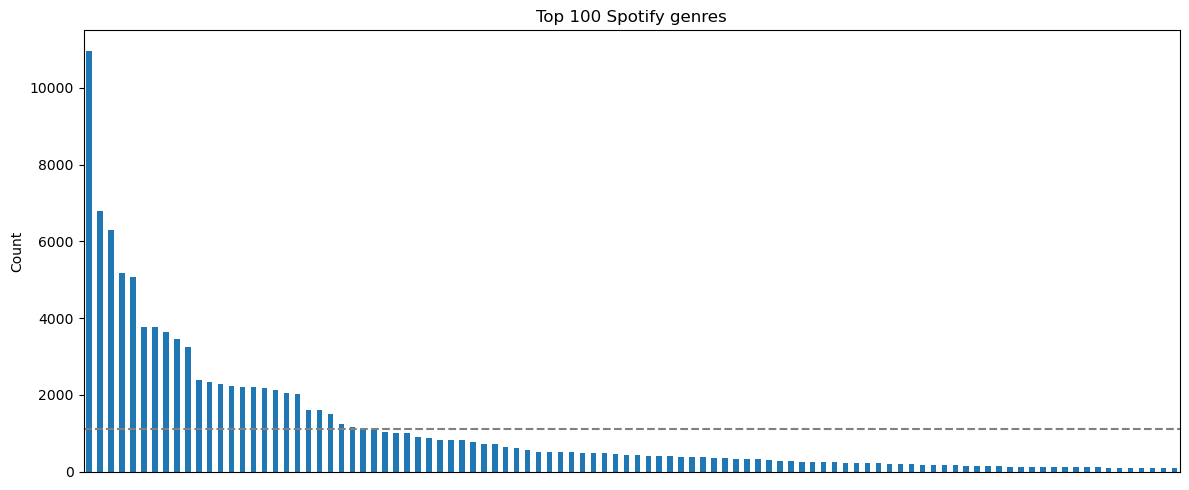

In [26]:

top_n = 100
top_counts = genre_counts.head(top_n)
y_mean = top_counts.mean()

plt.figure(figsize=(12, 5))
top_counts.plot(kind="bar")
plt.axhline(y_mean, linestyle="--", color='grey') # Add grey line representing the mean
plt.title(f"Top {min(top_n, len(genre_counts))} Spotify genres")
plt.xlabel("")
plt.ylabel("Count")

# Hide x-axis labels to keep the chart readable
plt.xticks([], [])
plt.tight_layout()
plt.show()


### Grouping genres into buckets

We’ll map specific labels to a small set of buckets:
- **pop** (pop, art pop, synthpop, hyperpop, britpop, etc.)
- **rock** (rock, indie rock, classic/prog/alt/shoegaze/post-rock)
- **hip_hop_rap** (hip hop, rap, trap, drill, boom bap, etc.)
- **rnb_soul** (r&b, neo soul, soul, motown)
- **electronic_dance** (edm, house, techno, trance, downtempo, vaporwave, future house, etc.)
- **jazz** (jazz, bebop, hard bop, fusion, vocal jazz, nu jazz, etc.)
- **classical_art** (classical, chamber, opera, minimalism, neoclassical, soundtrack/stage)
- **folk_country_americana** (folk, alt country, bluegrass, americana, singer-songwriter)
- **metal_hard** (metal, hardcore, metalcore, thrash, sludge, stoner, grindcore, etc.)
- **latin** (latin pop/jazz/folk, mpb, bossa nova, cumbia, reggaeton, salsa, bachata, etc.)
- **world_regional** (afrobeats/afrobeat/highlife/gnawa, fado, flamenco, k-pop/j-pop/mandopop, etc.)
- **experimental_avant** (experimental, avant-garde, noise, idm, ambient/drone, post-whatever)
- **other** (comedy, spoken word, reggae, rocksteady, dancehall, dub, “unknown”)

In [30]:
BUCKET_RULES = [
    ("hip_hop_rap",       ["hip hop", "rap", "trap", "drill", "boom bap", "g-funk", "grime"]),
    ("rnb_soul",          ["r&b", "rnb", "soul", "motown", "new jack swing", "neo soul", "philly soul"]),
    ("electronic_dance",  ["edm", "house", "techno", "trance", "disco", "vaporwave", "ambient", "downtempo",
                           "future house", "future bass", "progressive house", "slap house", "garage", "chillstep",
                           "chillwave", "psytrance", "moombahton", "big room", "eurodance", "italo disco",
                           "jersey club", "nightcore", "stutter house", "disco house", "dubstep", "electroclash"]),
    ("jazz",              ["jazz", "bebop", "hard bop", "fusion", "vocal jazz", "nu jazz", "cool jazz", "free jazz",
                           "jazz funk", "jazz house", "jazz blues", "jazz beats"]),
    ("classical_art",     ["classical", "chamber", "opera", "neoclassical", "minimalism", "baroque",
                           "soundtrack", "musicals", "orchestral"]),
    ("folk_country_americana", ["folk", "bluegrass", "americana", "singer-songwriter", "country", "alt country"]),
    ("metal_hard",        ["metal", "hardcore", "thrash", "grindcore", "sludge", "stoner", "post-hardcore",
                           "metalcore", "gothic metal", "power metal", "black metal", "nu metal", "melodic death"]),
    ("rock",              ["rock", "shoegaze", "post-rock", "post-punk", "proto-punk", "new wave", "glam rock",
                           "progressive rock", "math rock", "indie rock", "garage rock", "hard rock", "space rock",
                           "grunge", "power pop", "yacht rock", "classic rock", "art rock", "riot grrrl", "punk",
                           "surf rock", "rap rock", "krautrock"]),
    ("pop",               [" pop", "synthpop", "hyperpop", "art pop", "bedroom pop", "indie pop", "dance pop",
                           "power pop", "pop punk", "britpop", "city pop", "soft pop"]),
    ("latin",             ["latin", "mpb", "bossa nova", "samba", "cumbia", "reggaeton", "salsa", "bachata",
                           "bolero", "sertanejo", "pagode", "tecnobrega", "neoperreo", "calypso", "forro", "forró"]),
    # ("reggae_dancehall",  ["reggae", "dancehall", "rocksteady", "dub"]),
    ("world_regional",    ["fado", "flamenco", "afrobeat", "afrobeats", "highlife", "gnawa",
                           "k-pop", "kpop", "k-rap", "k rap", "k-rock", "k rock",
                           "j-pop", "jpop", "j-rap", "j rap", "j-rock", "j rock", "j-r&b", "mandopop",
                           "celtic", "mariachi", "kizomba", "kuduro", "bhangra", "pagode baiano",
                           "sertanejo", "funk carioca", "brazilian funk", "brazilian hip hop",
                           "turkish hip hop", "german hip hop", "french rap"]),
    ("experimental_avant",["experimental", "avant", "noise", "idm", "drone", "witch house", "psych", "post-"]),
]

def map_genre_to_bucket(genre):
    if not isinstance(genre, str) or not genre:
        return "other"
    g = genre.lower().strip()
    for bucket, needles in BUCKET_RULES:
        for needle in needles:
            if needle in g:
                return bucket
    if g in {"spoken word", "comedy"}:
        return "other"
    return "other"


In [31]:
# Map each unique genre to a bucket
unique_genres = pd.Series(sorted(flat_genres.unique()), name="genre")
bucket_df = unique_genres.to_frame().assign(bucket=unique_genres.map(map_genre_to_bucket))

bucket_counts = flat_genres.map(map_genre_to_bucket).value_counts()
y_mean_bucket = bucket_counts.mean()

# Also show bucket counts as a dataframe
bucket_counts_df = bucket_counts.rename_axis("bucket").reset_index(name="count")
bucket_counts_df


,bucket,count
0,hip_hop_rap,38120
1,rock,14190
2,pop,13957
3,other,12507
4,folk_country_americana,6785
5,rnb_soul,6744
6,classical_art,5618
7,world_regional,4040
8,latin,3369
9,jazz,2622


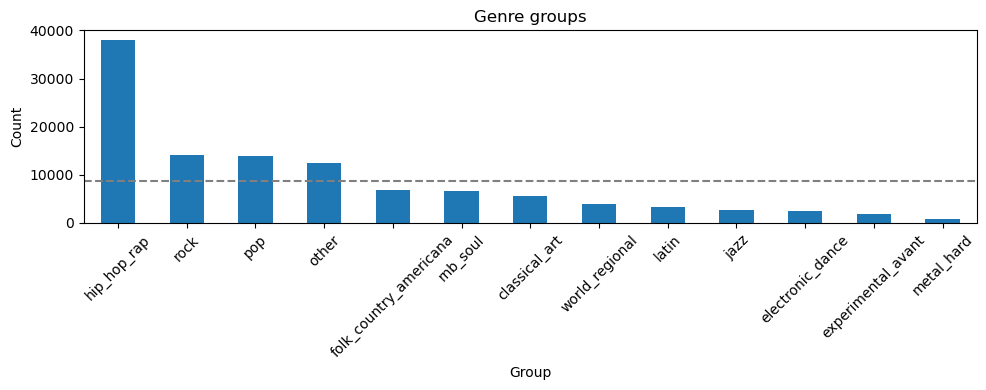

In [33]:
plt.figure(figsize=(10, 4))
bucket_counts.plot(kind="bar")
plt.axhline(y_mean_bucket, linestyle="--", color='grey')
plt.title("Genre groups")
plt.xlabel("Group")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


---


# Cleaning Path

We will prepare the data so it is consistent and easy to use later.

Plan:
- Look at the genres to understand how many there are and how they are distributed.
- Define a small set of genre groups and see how current genres fit into them.
- Later, create a cleaned dataset with consistent dates, a single duration field, simple numeric fixes, and grouped genres.
- After that, check the cleaned data again and continue the analysis.

Cleaning will happen outside of this notebook in {CLEAN_DATA_PATH - TO ADD}. We'll simply load the cleaned data afterwards for feature engineering and training the model.